# Run Training on Azure ML Compute Instance

In this exercise, we will run a deep learning training job on Azure ML Compute Instance


# Predicting cats versus dogs (binary classification)

## Dataset 

The original dataset is avalaible here: [cats and dogs](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)

Run the [downlload bash script](01_download_files.sh) to download the publich cats and dogs dataset and uploaded to a storage account. 

Run [Explore Dataset Notebook](02_explore_dataset.ipynb) to mount datstore to compute instance.

## Training Code

In [21]:
import tensorflow as tf
# Placeholder for student's code (3 lines of code)
# Task: import tensorflow and download the dataset locally

In [22]:
tf.version.VERSION

'2.8.0'

Enable MLflow tracking

In [23]:
import mlflow
mlflow.set_experiment('cats-and-dogs')
mlflow.autolog()

2022/04/25 05:33:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Data need to be present on the compute instance, or development machine. Refer to [explore data set notebook](02_explore_dataset.ipynb) for details on how to mount a registered `Dataset`. 

In [24]:
zip_dir = '/mnt/tmp/cats_dogs'
import pathlib
parent_dir = pathlib.Path(zip_dir)

import os 
print(os.listdir(zip_dir))

['train', 'validation', 'vectorize.py']


In [25]:
# Create 2 variable called train_dir and test_dir that will contain the path to the 'train' and 'validation' folders
train_dir = parent_dir / 'train'
test_dir = parent_dir / 'validation'

print(train_dir)
print(test_dir)

/mnt/tmp/cats_dogs/train
/mnt/tmp/cats_dogs/validation


### Preparing the Dataset

In [26]:
# Import ImageDataGenerator and create an image generator for the training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_img_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')


# create an image generator for the testing set
test_img_gen = ImageDataGenerator(rescale=1./255)

# batch size for the data generators.
batch_size=20

# define our data generator by specifying its input stream
train_data_gen = train_img_gen.flow_from_directory(
    batch_size=batch_size, 
    directory=train_dir, 
    target_size=(100, 100), 
    class_mode='binary')

test_data_gen = test_img_gen.flow_from_directory(
    batch_size=batch_size, 
    directory=test_dir, 
    target_size=(100, 100), 
    class_mode='binary')


print(test_data_gen.class_indices)

total_train = 2000
total_val = 1000

print(test_data_gen.image_shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
(100, 100, 3)


### Defining the Architecture of CNN

In [27]:
# import VGG16
from tensorflow.keras.applications import VGG16


# instantiate a model 
input_shape = (100, 100, 3)
base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# freeze layers of the base model
frozen_layers = 15
for layer in base_model.layers[:frozen_layers]:
    layer.trainable = False


print('base model summary')
base_model.summary()

base model summary
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25

In [28]:
# add 2 fully connected layers to this VGG16 model

from tensorflow.keras.layers import Flatten, Dense

tuned_model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(500, activation='relu'),
    Dense(1, activation='sigmoid')
])


# instantiate and Adam opetimizer with learning rate of .00001
optimizer = tf.keras.optimizers.Adam(0.00001)


# compile the model and specify loss function 
tuned_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print('tuned model summary')
tuned_model.summary()

tuned model summary
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 500)               2304500   
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 17,019,689
Trainable params: 9,384,425
Non-trainable params: 7,635,264
_________________________________________________________________


### Training and Evaluation of the Model

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# early stopping if model doesnot improve in 5 epochs 
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# decrease the learning rate by a factor of 0.2 if the model doesn't improve after 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)

# Model checkpoint location 
checkpoint_filepath = os.path.expanduser('~/cloudfiles/data/model_checkpoint/vgg_checkpoint')
print(checkpoint_filepath)

# save bes model weights during learning process
model_checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

/home/azureuser/cloudfiles/data/model_checkpoint/vgg_checkpoint


In [30]:
# Train for 50 epochs (unless stopped early by callback functions)
history = tuned_model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=50,
    validation_data=test_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[early_stop_cb, reduce_lr, model_checkpoint_cb]
)

<ipython-input-30-a9e64beea693>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = tuned_model.fit_generator(
2022/04/25 05:33:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '790f7fd1-abff-4b4f-9e10-8b93dc4828ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50
100/100 [==============================] - 83s 813ms/step - loss: 0.5559 - accuracy: 0.7100 - val_loss: 0.4073 - val_accuracy: 0.8070 - lr: 1.0000e-05
Epoch 2/50
100/100 [==============================] - 61s 609ms/step - loss: 0.4097 - accuracy: 0.8080 - val_loss: 0.3161 - val_accuracy: 0.8580 - lr: 1.0000e-05
Epoch 3/50
100/100 [==============================] - 62s 621ms/step - loss: 0.3539 - accuracy: 0.8365 - val_loss: 0.2981 - val_accuracy: 0.8690 - lr: 1.0000e-05
Epoch 4/50
100/100 [==============================] - 65s 650ms/step - loss: 0.3095 - accuracy: 0.8665 - val_loss: 0.3142 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 5/50
100/100 [==============================] - 61s 616ms/step - loss: 0.2933 - accuracy: 0.8655 - val_loss: 0.2838 - val_accuracy: 0.8820 - lr: 1.0000e-05
Epoch 6/50
100/100 [==============================] - 72s 720ms/step - loss: 0.2889 - accuracy: 0.8780 - val_loss: 0.2836 - val_accuracy: 0.8790 - lr: 1.0000e-05
Epoch 7/50
100/100 [========

2022/04/25 06:13:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_xzmc_v_/model, flavor: keras), fall back to return ['tensorflow==2.8.0', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


## Analysing the Results

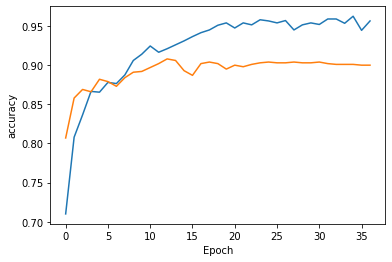

In [31]:
# plot the accuracy for the training and validation set
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()